In [1]:
import Bio.PDB
import numpy
import pandas as pd
import os
from Bio.PDB.Polypeptide import is_aa,three_to_one
from Bio.SeqUtils import seq1
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from collections import Counter
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

In [2]:
sns.set_context("talk")
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [4]:
def calc_residue_dist_CA(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    try:
        diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
        return numpy.sqrt(numpy.sum(diff_vector * diff_vector))
    except:
        return calc_residue_dist_2(residue_one,residue_two)

def calc_residue_dist_CB(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    try:
        diff_vector  = residue_one["CB"].coord - residue_two["CB"].coord
        return numpy.sqrt(numpy.sum(diff_vector * diff_vector))
    except:
        return calc_residue_dist_CA(residue_one,residue_two)
        

def calc_residue_dist_2(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    min_distance = 100
    for atom_one in residue_one:
        if atom_one.name.startswith("H"):
            continue
        for atom_two in residue_two:
            if atom_two.name.startswith("H"):
                continue
            diff_vector  = atom_one.coord - atom_two.coord
            dist = numpy.sqrt(numpy.sum(diff_vector * diff_vector))
            if dist<min_distance:
                min_distance = dist
    return min_distance

def calc_dist_matrix(chain_one, chain_two,method) :
    """Returns a matrix of C-alpha distances between two chains"""
    atoms_chain_one = [res for res in chain_one if is_aa(res)]
    atoms_chain_two =  [res for res in chain_two if is_aa(res)]
    answer = numpy.zeros((len(atoms_chain_one), len(atoms_chain_two)), numpy.float)
    #print(answer.shape)
    for row, residue_one in enumerate(atoms_chain_one) :
        for col, residue_two in enumerate(atoms_chain_two) :
            answer[row, col] = method(residue_one, residue_two)
    return answer

# VHH

In [28]:
vhh_FR2_CDR3_contact=[]

for pdb_filename in tqdm_notebook(os.listdir("NR_H_Protein_Martin")):
    try:
        #pdb_filename = next(pdb_iter)

        pdb_code = pdb_filename.split(".")[0]
        #print(f'process {pdb_code}')
        structure = Bio.PDB.PDBParser().get_structure(pdb_code, "./NR_H_Protein_Martin/"+pdb_filename)
        model = structure[0]
        H_chain = model['H']
        H_numbering = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in H_chain if is_aa(res)]
        definition = [ H_numbering.index("26"),
                  H_numbering.index("36"),
                  H_numbering.index("50"),
                  H_numbering.index("59"),
                  H_numbering.index("95"),
                  H_numbering.index("103"),
        ]
        FERL=[H_numbering.index('44'),
         H_numbering.index('44'),
            H_numbering.index('45'),
        H_numbering.index('47')]

        dist_matrix = calc_dist_matrix(H_chain, H_chain,calc_residue_dist_CA)

        CDR3_lenth = definition[5]-definition[4]

        if True in np.unique(np.hstack(dist_matrix[definition[4]:definition[5],FERL])<8):
            vhh_FR2_CDR3_contact.append((1,CDR3_lenth,pdb_code))
        else:
            vhh_FR2_CDR3_contact.append((0,CDR3_lenth,pdb_code))
    except Exception as e:
        print(pdb_filename)
        print(e)
        
    
        




    #dist_matrix = calc_dist_matrix(model["A"], model["H"])
    #seq_chain_one = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in model['H'] if is_aa(res)]
    #print(seq_chain_one)
    #seq_chain_two = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in model['A'] if is_aa(res)]
    #contact_map = dist_matrix < 12

/Users/zhesang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


.DS_Store
'utf-8' codec can't decode byte 0x87 in position 27: invalid start byte


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3747.
  PDBConstructionWarning)


Superimpose_45_103.pse
'utf-8' codec can't decode byte 0x88 in position 49: invalid start byte
5J57_1.pdb
'44' is not in list



In [6]:
def annotate(f):
    content = [i for i in open(f).read().splitlines() if i.startswith("REMARK")]
    molecue_id = None
    for l in content:
        if "CHAIN H" in l:
            molecue_id = l.split(" ")[-1]
            break
    for l in content:
        if f"SPECIES" in l:
            _mol = l.split(":")[1].strip()
            if _mol == molecue_id:
                if  "HOMO" in l and not "MUS" in l:
                    return "Human"
                else:
                    return "else"
    return None

In [7]:
human_ig_pdb = []

for i in os.listdir("NR_LH_Protein_Martin"):
    ret = annotate("NR_LH_Protein_Martin/"+i)
    if ret=="Human":
        human_ig_pdb.append(i)
        

# VH-VL

In [8]:
vh_FR2_CDR3_contact = []
for pdb_filename in tqdm_notebook(human_ig_pdb):
    try:
        #pdb_filename = next(pdb_iter)

        pdb_code = pdb_filename.split(".")[0]
        #print(f'process {pdb_code}')
        structure = Bio.PDB.PDBParser().get_structure(pdb_code, "./NR_LH_Protein_Martin/"+pdb_filename)
        model = structure[0]
        H_chain = model['H']
        H_numbering = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in H_chain if is_aa(res)]
        definition = [ H_numbering.index("26"),
                  H_numbering.index("36"),
                  H_numbering.index("50"),
                  H_numbering.index("59"),
                  H_numbering.index("95"),
                  H_numbering.index("103"),
        ]

        dist_matrix = calc_dist_matrix(H_chain, H_chain,calc_residue_dist_CA)

        CDR3_lenth = definition[5]-definition[4]
        VGLW=[H_numbering.index('37'),
         H_numbering.index('44'),
         H_numbering.index('45'),
         H_numbering.index('47')]


        if True in np.unique(np.hstack(dist_matrix[definition[4]:definition[5],VGLW])<8):
            vh_FR2_CDR3_contact.append((1,CDR3_lenth,pdb_code))
        else:
            vh_FR2_CDR3_contact.append((0,CDR3_lenth,pdb_code))
    except Exception as e:
        print(pdb_filename)
        print(e)

/Users/zhesang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1726.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1909.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 1844.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 1852.
  PDBConstructionWarning)


6MTT_1.pdb
'44' is not in list


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 1925.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1968.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 1979.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1990.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 2012.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: 

6CT7_1.pdb
'95' is not in list


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3336.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4504.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 3730.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 3747.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 3761.
  PDBConstructionWarning)
/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: 

In [59]:
def length_class(x):
    if x<5:
        return "<5"
    elif x<10:
        return "5~10"
    elif x<15:
        return "10~15"
    elif x<20:
        return "15~20"
    else:
        return ">20"

In [61]:
vh_df = pd.DataFrame(vh_FR2_CDR3_contact,columns = ['contact','CDR3 length','pdb_code'])
vhh_df = pd.DataFrame(vhh_FR2_CDR3_contact,columns = ['contact','CDR3 length','pdb_code'])
vh_df['length_group'] = vh_df['CDR3 length'].apply(lambda x : length_class(x))
vhh_df['length_group'] = vhh_df['CDR3 length'].apply(lambda x : length_class(x))
vh_df['%'] = np.ones(vh_df.shape[0])
vhh_df['%'] = np.ones(vhh_df.shape[0])
vh_df['type']='Human IgG'
vhh_df['type']='Nb'
CDR3_FR2_contact = pd.concat([vhh_df,vh_df])

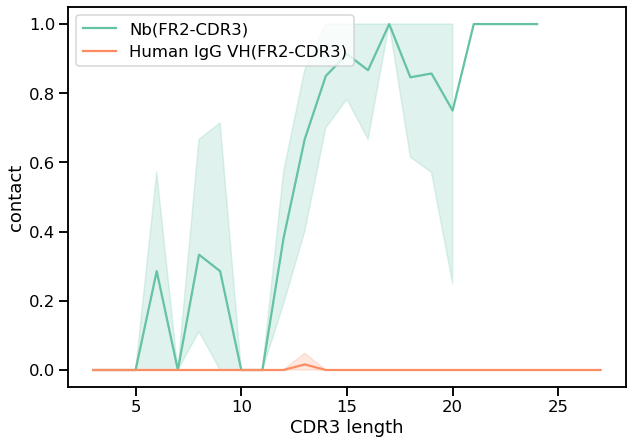

In [57]:
fig,axes = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(x='CDR3 length',y='contact',data=vhh_df,ax=axes,label='Nb(FR2-CDR3)')
sns.lineplot(x='CDR3 length',y='contact',data=vh_df,ax=axes,label='Human IgG VH(FR2-CDR3)')
plt.legend(loc="upper left")
plt.savefig("FR2-CDR3_contacts_CDR3 length.pdf",format='pdf')

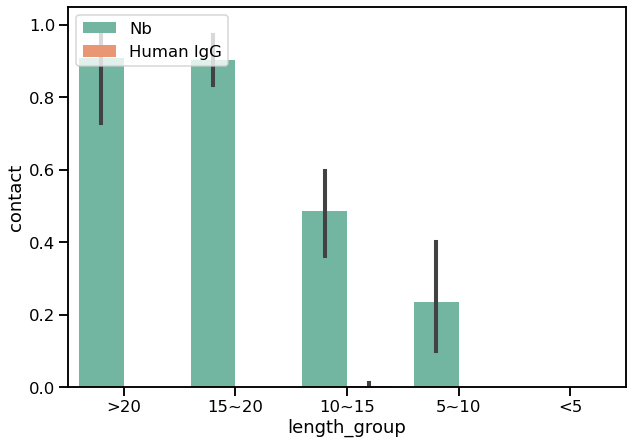

In [63]:
fig,axes = plt.subplots(1,1,figsize=(10,7))
sns.barplot(x='length_group',y='contact',hue='type',data=CDR3_FR2_contact,ax=axes)
plt.legend(loc="upper left")

In [33]:
vhh_FR2_CDR3_contact_mean = vhh_df.groupby("CDR3 length")['contact'].mean()

CDR3 length
3     0.000000
4     0.000000
5     0.000000
6     0.285714
7     0.000000
8     0.333333
9     0.285714
10    0.000000
11    0.000000
12    0.380952
13    0.666667
14    0.850000
15    0.913043
16    0.866667
17    1.000000
18    0.846154
19    0.857143
20    0.750000
21    1.000000
22    1.000000
23    1.000000
24    1.000000
Name: contact, dtype: float64

Text(0, 0.5, '')

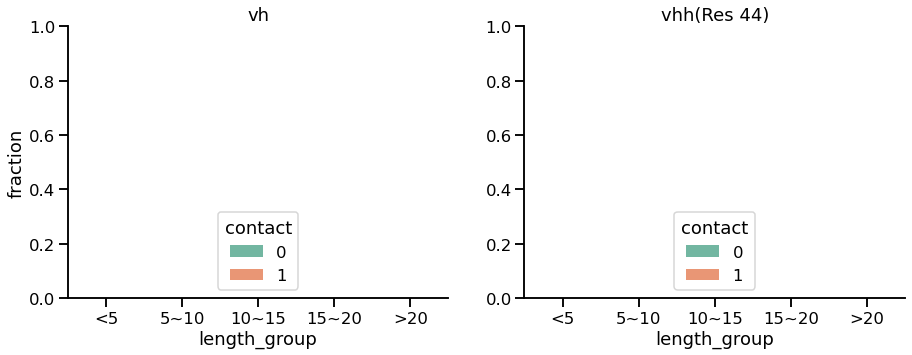

In [24]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.barplot(x='length_group',y='%',hue='contact',order=["<5","5~10","10~15","15~20",">20"],
            data=(vh_df.groupby(['length_group','contact']).agg({'%':'sum'})/vh_df.groupby('length_group').agg({'%':'sum'})).reset_index(),ax=ax1)
sns.despine()
ax1.set_title("vh")
ax1.set_ylim((0,1))
ax1.set_ylabel("fraction")


ax2 = fig.add_subplot(122)
sns.barplot(x='length_group',y='%',hue='contact',order=["<5","5~10","10~15","15~20",">20"],
            data=(vhh_df.groupby(['length_group','contact']).agg({'%':'sum'})/vhh_df.groupby('length_group').agg({'%':'sum'})).reset_index(),ax=ax2)
sns.despine()
ax2.set_title("vhh(Res 44)")
ax2.set_ylim((0,1))
ax2.set_ylabel("")




Text(0.5, 1.0, 'vhh')

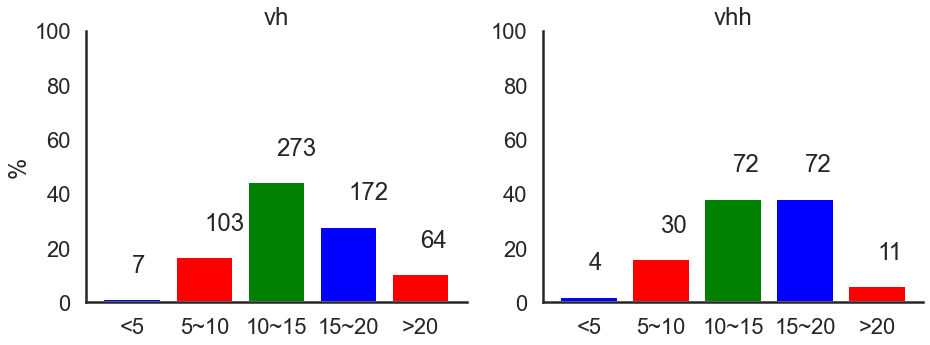

In [93]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
reordered_count_1 = vh_df['length_group'].value_counts()[["<5","5~10","10~15","15~20",">20"]]
x1 = reordered_count_1.index
y1 = reordered_count_1.values
p1 = 100*y1/np.sum(y1)
ax1.bar(x1,p1,color=['b','r','g'])

for _ind,_p in enumerate(p1):
    ax1.text(_ind,_p+10,str(round(y1[_ind],2)))
sns.despine()
ax1.set_ylabel("%")
ax1.set_ylim(ymax=100)
ax1.set_title("vh")



ax2 = fig.add_subplot(122)
reordered_count_2 = vhh_df['length_group'].value_counts()[["<5","5~10","10~15","15~20",">20"]]

x2 = reordered_count_2.index
y2 = reordered_count_2.values
p2 = 100*y2/np.sum(y2)
ax2.bar(x2,p2,color=['b','r','g'])

for _ind,_p in enumerate(p2):
    ax2.text(_ind,_p+10,str(round(y2[_ind],2)))
    
    
sns.despine()
ax2.set_ylabel("")
ax2.set_ylim(ymax=100)
ax2.set_title("vhh")

In [53]:
vhh_45_103_contact=[]

for pdb_filename in tqdm_notebook(os.listdir("NR_H_Protein_Martin")):
    try:
        #pdb_filename = next(pdb_iter)

        pdb_code = pdb_filename.split(".")[0]
        #print(f'process {pdb_code}')
        structure = Bio.PDB.PDBParser().get_structure(pdb_code, "./NR_H_Protein_Martin/"+pdb_filename)
        model = structure[0]
        H_chain = model['H']
        residues = [res for res in H_chain if is_aa(res)]
        H_numbering = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in H_chain if is_aa(res)]
        pos_45 = H_numbering.index('37')
        pos_103 = H_numbering.index('103')
        res_45 = residues[pos_45]
        res_103 = residues[pos_103]
        
        distance = calc_residue_dist_2(res_45,res_103)
        
        vhh_45_103_contact.append((f"{three_to_one(res_45.get_resname())}-{three_to_one(res_103.get_resname())}",distance))
    except Exception as e:
        print(pdb_filename)
        print(e)
        
    
    #dist_matrix = calc_dist_matrix(model["A"], model["H"])
    #seq_chain_one = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in model['H'] if is_aa(res)]
    #print(seq_chain_one)
    #seq_chain_two = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in model['A'] if is_aa(res)]
    #contact_map = dist_matrix < 12

/Users/zhesang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


.DS_Store
'utf-8' codec can't decode byte 0x87 in position 27: invalid start byte


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3747.
  PDBConstructionWarning)


Superimpose_45_103.pse
'utf-8' codec can't decode byte 0x88 in position 49: invalid start byte



In [49]:
df_45_103 = pd.DataFrame(vhh_45_103_contact,columns=['pair','dist'])
df_45_103['class'] = df_45_103['pair'].apply(lambda x: "R45-W103" if x=='R-W' else 'other')


summary_45_103 = df_45_103.groupby('class',as_index=False).agg({"dist":[np.mean,np.std,'count']})

In [54]:
df_45_103 = pd.DataFrame(vhh_45_103_contact,columns=['pair','dist'])
df_45_103['class'] = df_45_103['pair'].apply(lambda x: "F/Y37-W103" if (x=='F-W') or (x=="Y-W") else 'other')


summary_45_103 = df_45_103.groupby('class',as_index=False).agg({"dist":[np.mean,np.std,'count']})

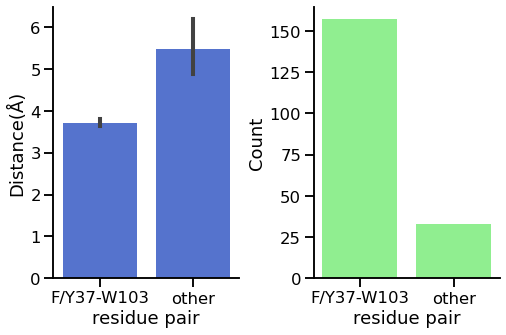

In [55]:
fig=plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(121)
sns.barplot(x='class',y='dist',data=df_45_103,color='royalblue',ax=ax1)
ax1.set_ylabel("Distance(Å)")
ax1.set_xlabel("residue pair")
sns.despine()

ax2 = fig.add_subplot(122)
ax2.bar(summary_45_103['class'],summary_45_103[( 'dist', 'count')],color='lightgreen')
#sns.barplot(x='class',y='count',data=summary_45_103,color='purple',ax=ax2)
ax2.set_ylabel("Count")
ax2.set_xlabel("residue pair")
sns.despine()

fig.subplots_adjust(wspace=0.4)
plt.savefig("prevalence_37_103.pdf",format='pdf')

In [202]:
df_37_100X= pd.DataFrame(vhh_45_103_contact,columns=['pair','dist'])
df_37_100X['class'] = df_37_100X['pair'].apply(lambda x:classify_pi(x))
summary_37_100X = df_37_100X.groupby('class',as_index=False).agg({"dist":[np.mean,np.std,'count']})

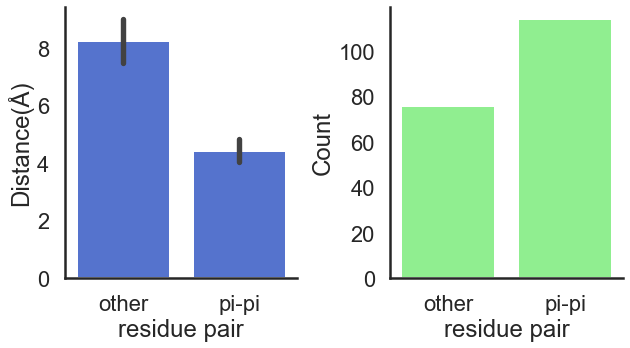

In [208]:
fig=plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
sns.barplot(x='class',y='dist',data=df_37_100X,color='royalblue',ax=ax1,order=['other','pi-pi'])
ax1.set_ylabel("Distance(Å)")
ax1.set_xlabel("residue pair")
sns.despine()

ax2 = fig.add_subplot(122)
ax2.bar(summary_37_100X['class'],summary_37_100X[( 'dist', 'count')],color='lightgreen')
#sns.barplot(x='class',y='count',data=summary_45_103,color='purple',ax=ax2)
ax2.set_ylabel("Count")
ax2.set_xlabel("residue pair")
sns.despine()

fig.subplots_adjust(wspace=0.4)

In [197]:
def classify_pi(x):
    aa1,aa2 = x.split("-")
    if aa1 in 'FWY' and aa2 in 'FWY':
        return 'pi-pi'
    return 'other'

In [ ]:
FERL=[H_numbering.index('44')]
         #H_numbering.index('44'),
         #H_numbering.index('45'),
         #H_numbering.index('47')]

In [94]:
x=None
vhh_FR2_CDR3_contact=[]

for pdb_filename in tqdm_notebook(os.listdir("NR_H_Protein_Martin")):
    try:
        #pdb_filename = next(pdb_iter)

        pdb_code = pdb_filename.split(".")[0]
        #print(f'process {pdb_code}')
        structure = Bio.PDB.PDBParser().get_structure(pdb_code, "./NR_H_Protein_Martin/"+pdb_filename)
        model = structure[0]
        H_chain = model['H']
        H_numbering = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in H_chain if is_aa(res)]
        definition = [ H_numbering.index("26"),
                  H_numbering.index("36"),
                  H_numbering.index("50"),
                  H_numbering.index("59"),
                  H_numbering.index("95"),
                  H_numbering.index("103"),
        ]
        FERL=[H_numbering.index('37'),
         H_numbering.index('44'),
         H_numbering.index('45'),
         H_numbering.index('47')]

        dist_matrix = calc_dist_matrix(H_chain, H_chain,calc_residue_dist_CA)

        CDR3_lenth = definition[5]-definition[4]
        
        FR2_CDR3_contact = (dist_matrix[definition[4]:definition[5],FERL].min(0)<8).astype(int)
        vhh_FR2_CDR3_contact.append([FR2_CDR3_contact,CDR3_lenth])

    except Exception as e:
        print(pdb_filename)
        print(e)
        
    
        




    #dist_matrix = calc_dist_matrix(model["A"], model["H"])
    #seq_chain_one = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in model['H'] if is_aa(res)]
    #print(seq_chain_one)
    #seq_chain_two = ["".join(np.array(res.id).astype(str)).replace(" ","") for res in model['A'] if is_aa(res)]
    #contact_map = dist_matrix < 12

/Users/zhesang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


.DS_Store
'utf-8' codec can't decode byte 0x87 in position 27: invalid start byte


/Users/zhesang/anaconda3/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 3747.
  PDBConstructionWarning)


Superimpose_45_103.pse
'utf-8' codec can't decode byte 0x88 in position 49: invalid start byte
5J57_1.pdb
'44' is not in list

